<a href="https://colab.research.google.com/github/NikolaevMikhailRoma/ML_projects/blob/master/ML_object_segmentation_UNET%2C%20PSPNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libs

In [72]:
# Основа для модели нейронной сети
from tensorflow.keras.models import Model

# Стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization,UpSampling2D

# Оптимизатор Adam
from tensorflow.keras.optimizers import Adam

# Дополнительные утилиты keras
from tensorflow.keras import utils

# Инструменты для построения графиков
import matplotlib.pyplot as plt

# Инструменты для работы с изображениями
from tensorflow.keras.preprocessing import image

# Инструменты для работы с массивами
import numpy as np

# Системные инструменты
import time, random, gdown, os

# Дополнительные инструменты для работы с изображениями
from PIL import Image

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Дополнительные инструменты визуализации
import seaborn as sns
sns.set_style('darkgrid')

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# очистка ОЗУ
import gc

# Giperparams

In [54]:
# Глобальные параметры

IMG_WIDTH = 128               # Ширина картинки 
IMG_HEIGHT = 128              # Высота картинки 
CLASS_COUNT = 16              # Количество классов на изображении
TRAIN_DIRECTORY = 'train'     # Название папки с файлами обучающей выборки
VAL_DIRECTORY = 'val'         # Название папки с файлами проверочной выборки
# TRAIN_DIRECTORY = 'object_segmentation_1/train'     # Название папки с файлами обучающей выборки
# VAL_DIRECTORY = 'object_segmentation_1/val'         # Название папки с файлами проверочной выборки

# Цвета пикселов сегментированных изображений

FLOOR = (100, 100, 100)         # Пол (серый)
CEILING = (0, 0, 100)           # Потолок (синий)
WALL = (0, 100, 0)              # Стена (зеленый)
COLUMN = (100, 0, 0)            # Колонна (красный)
APERTURE = (0, 100, 100)        # Проем (темно-бирюзовый)
DOOR = (100, 0, 100)            # Дверь (бордовый)
WINDOW = (100, 100, 0)          # Окно (золотой)
EXTERNAL = (200, 200, 200)      # Внешний мир (светло-серый)
RAILINGS = (0, 200, 0)          # Перила (светло-зеленый)
BATTERY = (200, 0, 0)           # Батареи (светло-красный)
PEOPLE = (0, 200, 200)          # Люди (бирюзовый)
LADDER = (0, 0, 200)            # Лестница (светло-синий)
INVENTORY = (200, 0, 200)       # Инвентарь (розовый)
LAMP = (200, 200, 0)            # Лампа (желтый)
WIRE = (0, 100, 200)            # Провод (голубой)
BEAM = (100, 0, 200)            # Балка (фиолетовый)

CLASS_LABELS = (FLOOR, CEILING, WALL, COLUMN, APERTURE, DOOR, WINDOW, EXTERNAL, RAILINGS, BATTERY, PEOPLE, LADDER, INVENTORY, LAMP, WIRE, BEAM)

# Service functions

In [55]:
# Служебная функция загрузки выборки изображений из файлов в папке

def load_imageset(folder,   # имя папки
                  subset,   # подмножество изображений - оригинальные или сегментированные
                  title     # имя выборки
                  ):

    # Cписок для хранения изображений выборки
    image_list = []

    # Отметка текущего времени
    cur_time = time.time()

    # Для всех файлов в каталоге по указанному пути:
    for filename in sorted(os.listdir(f'{folder}/{subset}')):

        # Чтение очередной картинки и добавление ее в список изображений требуемого размера
        image_list.append(image.load_img(os.path.join(f'{folder}/{subset}', filename),
                                         target_size=(IMG_WIDTH, IMG_HEIGHT)))

        # Вывод времени загрузки картинок выборки
    print('{} выборка загружена. Время загрузки: {:.2f} с'.format(title,
                                                                  time.time() - cur_time))

    # Вывод количества элементов в выборке
    print('Количество изображений:', len(image_list))

    return image_list

## process_image

In [50]:
def process_images(model = None,        # обученная модель
                   count = 5,     # количество случайных картинок для сегментации
                   show_prediction = False):
   # Генерация случайного списка индексов в количестве count между (0, len(x_val)
    indexes = np.random.randint(0, len(x_val), count)
    if show_prediction:
     
        fig_size, subplots_y = (26,15), 3
        # Вычисление предсказания сети для картинок с отобранными индексами
        predict = np.argmax(model.predict(x_val[indexes]), axis=-1)
        orig = labels_to_rgb(predict[..., None])

    else:
        fig_size, subplots_y = (26,10), 2
        orig = None

    

    # Подготовка цветов классов для отрисовки предсказания
    fig, axs = plt.subplots(subplots_y, count, figsize=fig_size)

    # Отрисовка результата работы модели
    for i in range(count):

        # Отображение на графике во второй линии сегментированного изображения из y_val
        axs[0, 0].set_title('Оригинальное сегментированное')
        axs[0, i].imshow(val_segments[indexes[i]])
        axs[0 ,i].axis('off')

        # Отображение на графике в третьей линии оригинального изображения
        axs[1, 0].set_title('Оригинальное изображение')
        axs[1, i].imshow(val_images[indexes[i]])
        axs[1 ,i].axis('off')
        if show_prediction:
            # Отображение на графике в первой линии предсказания модели
            axs[2, 0].set_title('Результат работы модели:')
            axs[2, i].imshow(orig[i])
            axs[2, i].axis('off')

    plt.show()

## rgb_to_labels, labels_to_rgb

In [5]:
# Функция преобразования цветного сегментированного изображения в метки классов

def rgb_to_labels(image_list  # список цветных изображений 
                 ):

    result = []
  
    # Для всех картинок в списке:
    for d in image_list:
        sample = np.array(d)
        # Создание пустой 1-канальной картики
        y = np.zeros((IMG_WIDTH, IMG_HEIGHT, 1), dtype='uint8')
        
        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS): 
            # Нахождение 3-х канальных пикселей классов и занесение метки класса
            y[np.where(np.all(sample == CLASS_LABELS[i], axis=-1))] = i 

        result.append(y)
  
    return np.array(result)

# Функция преобразования тензора меток класса в цветное сегметрированное изображение

def labels_to_rgb(image_list  # список одноканальных изображений
                  ):

    result = []

    # Для всех картинок в списке:
    for y in image_list:
        # Создание пустой цветной картики
        temp = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype='uint8')

        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS):
            # Нахождение пикселов класса и заполнение цветом из CLASS_LABELS[i]
            temp[np.where(np.all(y==i, axis=-1))] = CLASS_LABELS[i]

        result.append(temp)

    return np.array(result)


# Dataset procession

In [8]:
# Загрузка
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip', None, quiet=False)
# Распаковка архива
!unzip -qo construction_256x192.zip

Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip
To: /content/construction_256x192.zip
100%|██████████| 214M/214M [00:22<00:00, 9.58MB/s]


In [56]:
# Загрузка входных изображений

train_images = load_imageset(TRAIN_DIRECTORY, 'original', 'Обучающая')
val_images = load_imageset(VAL_DIRECTORY, 'original', 'Проверочная')

# Загрузка выходных (сегментированных) изображений

train_segments = load_imageset(TRAIN_DIRECTORY, 'segment', 'Обучающая')
val_segments = load_imageset(VAL_DIRECTORY, 'segment', 'Проверочная')

Обучающая выборка загружена. Время загрузки: 0.40 с
Количество изображений: 1900
Проверочная выборка загружена. Время загрузки: 0.02 с
Количество изображений: 100
Обучающая выборка загружена. Время загрузки: 0.38 с
Количество изображений: 1900
Проверочная выборка загружена. Время загрузки: 0.02 с
Количество изображений: 100


In [57]:
# Формирование обучающей выборки

x_train = []                          # Cписок под обучающую выборку

for img in train_images:              # Для всех изображений выборки:
    x = image.img_to_array(img)       # Перевод изображения в numpy-массив формы: высота x ширина x количество каналов
    x_train.append(x)                 # Добавление элемента в x_train

x_train = np.array(x_train)           # Перевод всей выборки в numpy
print(x_train.shape)                  # Форма x_train

# Формирование проверочной выборки

x_val = []                            # Cписок под проверочную выборку

for img in val_images:                # Для всех изображений выборки:
    x = image.img_to_array(img)       # Перевод изображения в numpy-массив формы: высота x ширина x количество каналов
    x_val.append(x)                   # Добавление элемента в x_train

x_val = np.array(x_val)               # Перевод всей выборки в numpy
print(x_val.shape)                    # Форма x_train

# Преобразование сегментов в метки классов

y_train = rgb_to_labels(train_segments)
y_val = rgb_to_labels(val_segments)

print(y_train.shape)
print(y_val.shape)

(1900, 128, 128, 3)
(100, 128, 128, 3)
(1900, 128, 128, 1)
(100, 128, 128, 1)


## Параметры для модификации датасета. Сокращаем кол-во классов до семи

In [58]:
NEW_CLASSES =((FLOOR),
              (CEILING),
              (WALL),
              (APERTURE, DOOR, WINDOW), 
              (COLUMN, RAILINGS, LADDER),
              (INVENTORY),
              (LAMP, WIRE, BEAM, EXTERNAL, BATTERY, PEOPLE))

new_set_classec = []

for set_cls in NEW_CLASSES: # Проходимся по NEW_CLASSES
    n_cls = []    
    
    for i in range(len(CLASS_LABELS)): # Проходимся по CLASSES
        # сравниваем и при совпадении условия присваиваем номер старого класса
        if CLASS_LABELS[i] in set_cls or CLASS_LABELS[i] == set_cls:
            n_cls.append(i)
    new_set_classec.append(n_cls)

print('Список номеров базовых классов, сгруппированных в новые классы:')

new_set_classec  

Список номеров базовых классов, сгруппированных в новые классы:


[[0], [1], [2], [4, 5, 6], [3, 8, 11], [12], [7, 9, 10, 13, 14, 15]]

In [59]:
# # создаем копии 
# yTrain7 = yTrain.copy()
# yVal7 = yVal.copy()

# получаем new_cls номер нового класса и set_cls набор старых классов, к нему относящихся
for new_cls, set_cls in enumerate(new_set_classec):
   
   # получаем base_cls базовые классы, входящие в набор set_cls
   for base_cls in set_cls:
       y_train[y_train == base_cls] = new_cls
       y_val[y_val == base_cls] = new_cls

NUM_CLASSES = len(new_set_classec)
NUM_CLASSES

7

## Show data

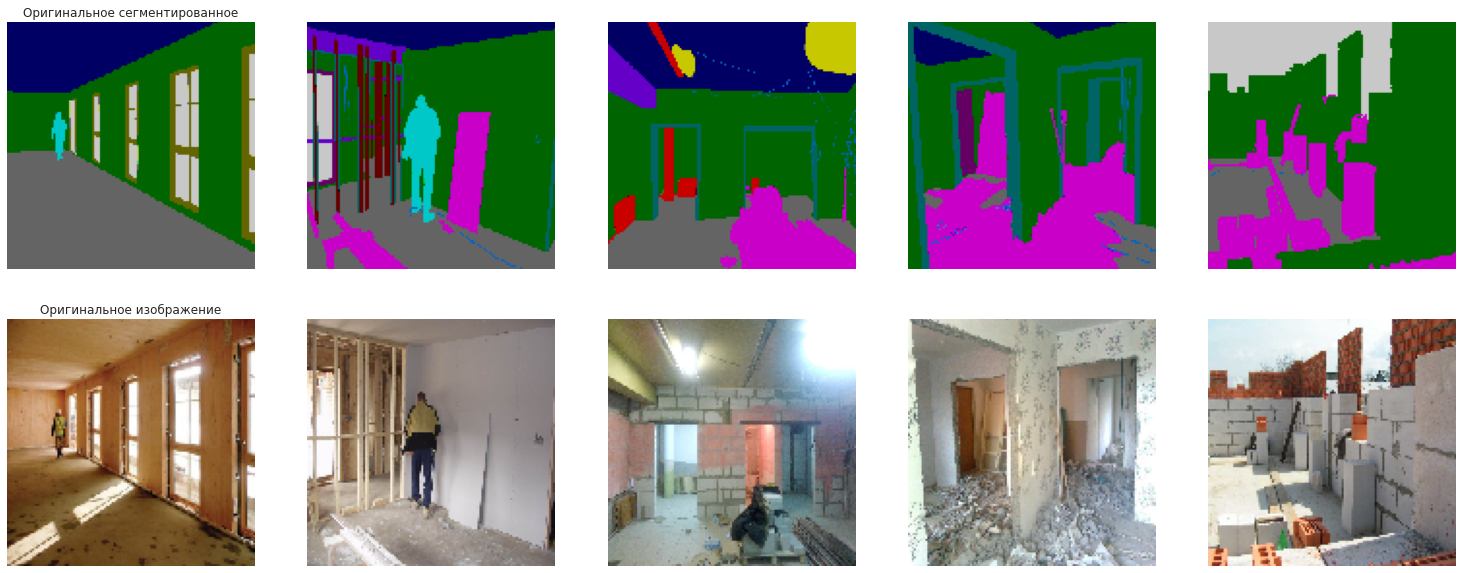

In [60]:
process_images(count = 5)

# Model UNET

In [18]:
# Функция визуализации процесса сегментации изображений

def unet(class_count,   # количество классов
         input_shape    # форма входного изображения
         ):

    img_input = Input(input_shape)                                          # Создаем входной слой формой input_shape

    ''' Block 1 '''
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)  # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)          # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 2 '''
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 3 '''
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 4 '''
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out

    ''' UP 2 '''
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                       # Объединяем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP 3 '''
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                       # Объединяем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP 4 '''
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)      # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_1_out])                                       # Объединяем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(class_count, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(learning_rate=1e-2),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    # Возвращаем сформированную модель
    return model

In [19]:
# Создание модели и вывод сводки по архитектуре


model_unet = unet(CLASS_COUNT,
                  (IMG_WIDTH, IMG_HEIGHT, 3))

model_unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 192, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_38 (BatchN  (None, 192, 256, 64  256        ['block1_conv1[0][0]']           
 ormalization)                  )                                                           

In [20]:
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss',
                                      factor=0.1, 
                                      patience=1, 
                                      verbose=0,
                                      min_lr=0.0001)
earlystop=EarlyStopping(monitor='val_loss', 
                        
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None,
                        restore_best_weights=True)

# Обучение модели

history = model_unet.fit(x_train, y_train,
                         epochs=50, batch_size=32,
                         callbacks=[earlystop, 
                                    reduceLROnPlateau, 
                                    # model_checkpoint_callback
                                    ],
                         validation_data=(x_val, y_val))

Epoch 1/50
60/60 [==============================] - 85s 1s/step - loss: 1.4726 - sparse_categorical_accuracy: 0.5067 - val_loss: 80780.6562 - val_sparse_categorical_accuracy: 0.1052 - lr: 0.0100
Epoch 2/50
60/60 [==============================] - 83s 1s/step - loss: 1.2921 - sparse_categorical_accuracy: 0.5321 - val_loss: 1207.5366 - val_sparse_categorical_accuracy: 0.0985 - lr: 0.0100
Epoch 3/50
43/60 [====================>.........] - ETA: 23s - loss: 1.1820 - sparse_categorical_accuracy: 0.5573

KeyboardInterrupt: ignored

In [21]:
# Отображение графиков обучения модели

plt.figure(figsize=(14, 7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

NameError: ignored

<Figure size 1008x504 with 0 Axes>

1/1 [==============================] - 2s 2s/step


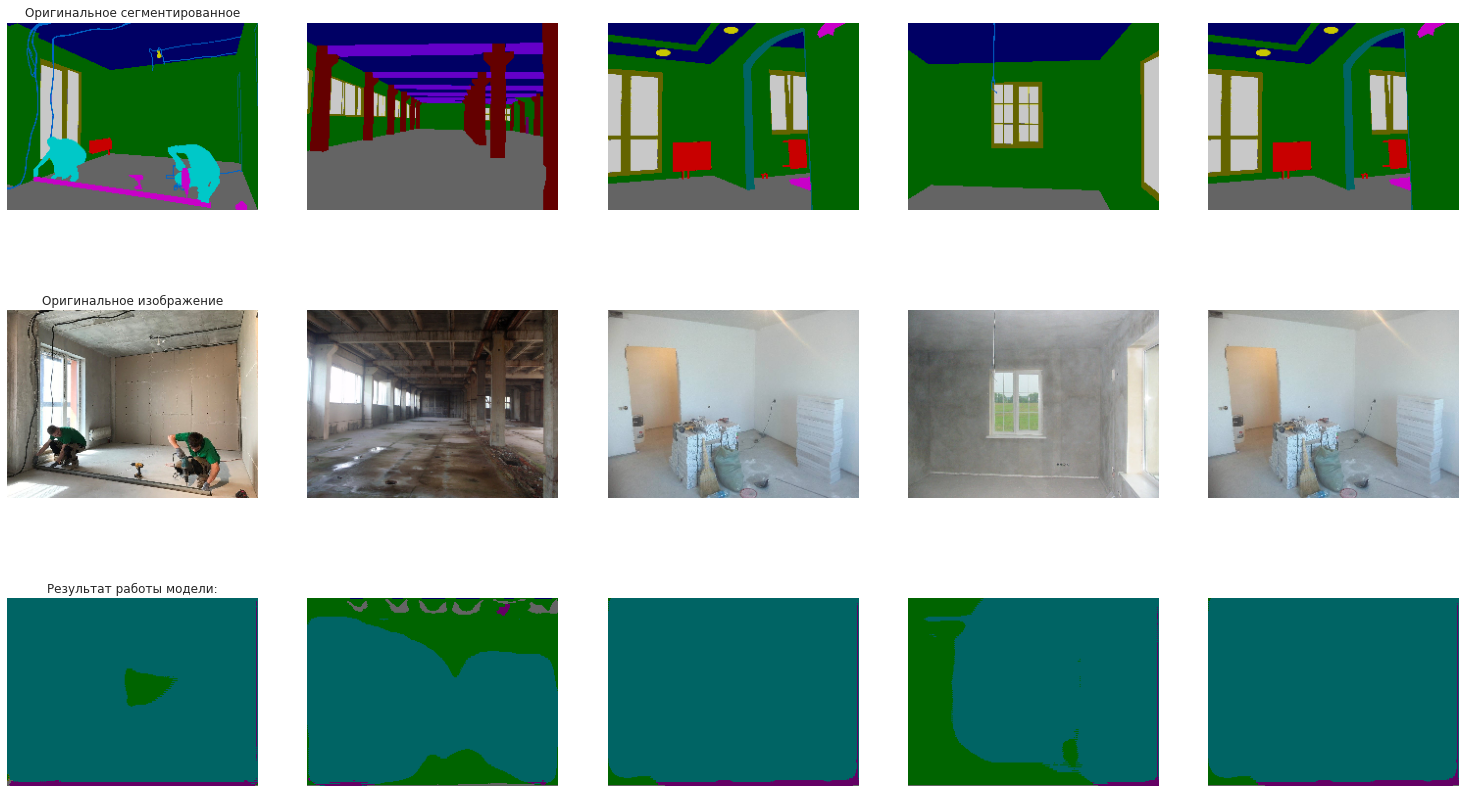

In [24]:
# Отображение результатов работы модели

process_images(model_unet, 5, show_prediction=True)

# Model PSP_NET

In [61]:
def PSPNet_construct(num_classes, # количество классов
                     input_shape, # размерность карты сегментации
                     filter_main = 32,
                     kernel_main = (3,3), # размер окна входных и выходных сверточных слоев
                     filter_piramid = 64, # размер свертки внутри PSPnet блоков
                     kernel_piramid = (2,2), # размер окна внутри PSPnet блоков
                     kernel_out = (3,3), # размер окна выходного блока
                     activ_main = 'relu', # функция активации входных и выходных сверточных слоев
                     activ_piramid = 'relu', # функция активации внутри PSPnet блоков
                     levels_piramid = 4 # количество PSPnet блоков 
                     ):

    # Подфункция для формирования PSPnet блока
    def pyramid_block(input,
                      frame,
                      filter,
                      kernel, 
                      activ
                      ):
        x = MaxPooling2D(pool_size=frame)(input)                                
        x = Conv2D(filter, kernel, padding='same')(x)  
        x = BatchNormalization()(x)    
        x = Activation(activ)(x)     
        out = UpSampling2D(size=frame)(x)                      
        
        return out
 
    # Создаем список окон для PSPnet блока
    frames_pyramid = [2**i for i in range(1,levels_piramid+1)]

    # Создаем входной слой с размерностью input_shape
    img_input = Input(input_shape)                                                         
  
    # Входной блок 
    x = Conv2D(filter_main, kernel_main, padding='same', name='conv_in')(img_input)         
    x = BatchNormalization()(x)                                                       
    conv_in = Activation(activ_main)(x)

    ################    PSPNet блоки  ###################################
    features = [] # список features от PSPnet блока для конкетинации
   
    # Формируем блоки согласно списка
    for frame in frames_pyramid:
        pyramid_main = pyramid_block(img_input,
                                     frame,
                                     filter_piramid,
                                     kernel_piramid,
                                     activ_piramid)
        features.append(pyramid_main)
    
    # Соединяем полученные данные из разных блоков
    x = concatenate(features)
    x = Conv2D(filter_main, kernel_main, padding='same', name='conc_main')(x)       
    x = BatchNormalization()(x)
    conc_main = Activation(activ_main)(x)

    # Соединяем текущие данные с данными со входа
    conc = concatenate([conc_main,  conv_in])
    x = Conv2D(filter_main, kernel_main, padding='same')(conc)                            
    x = BatchNormalization()(x)                                              
    x = Activation(activ_main)(x)                                               
               
   #############################################################################

    # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов
    x = Conv2D(num_classes, kernel_out, activation='softmax', padding='same')(x) 
    
    # Создаем модель с входом 'img_input' и выходом 'x'
    model = Model(img_input, x)                                             

    return model # Возвращаем предварительную модель

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 max_pooling2d_107 (MaxPooling2  (None, 64, 64, 3)   0           ['input_24[0][0]']               
 D)                                                                                               
                                                                                                  
 max_pooling2d_108 (MaxPooling2  (None, 32, 32, 3)   0           ['input_24[0][0]']               
 D)                                                                                         

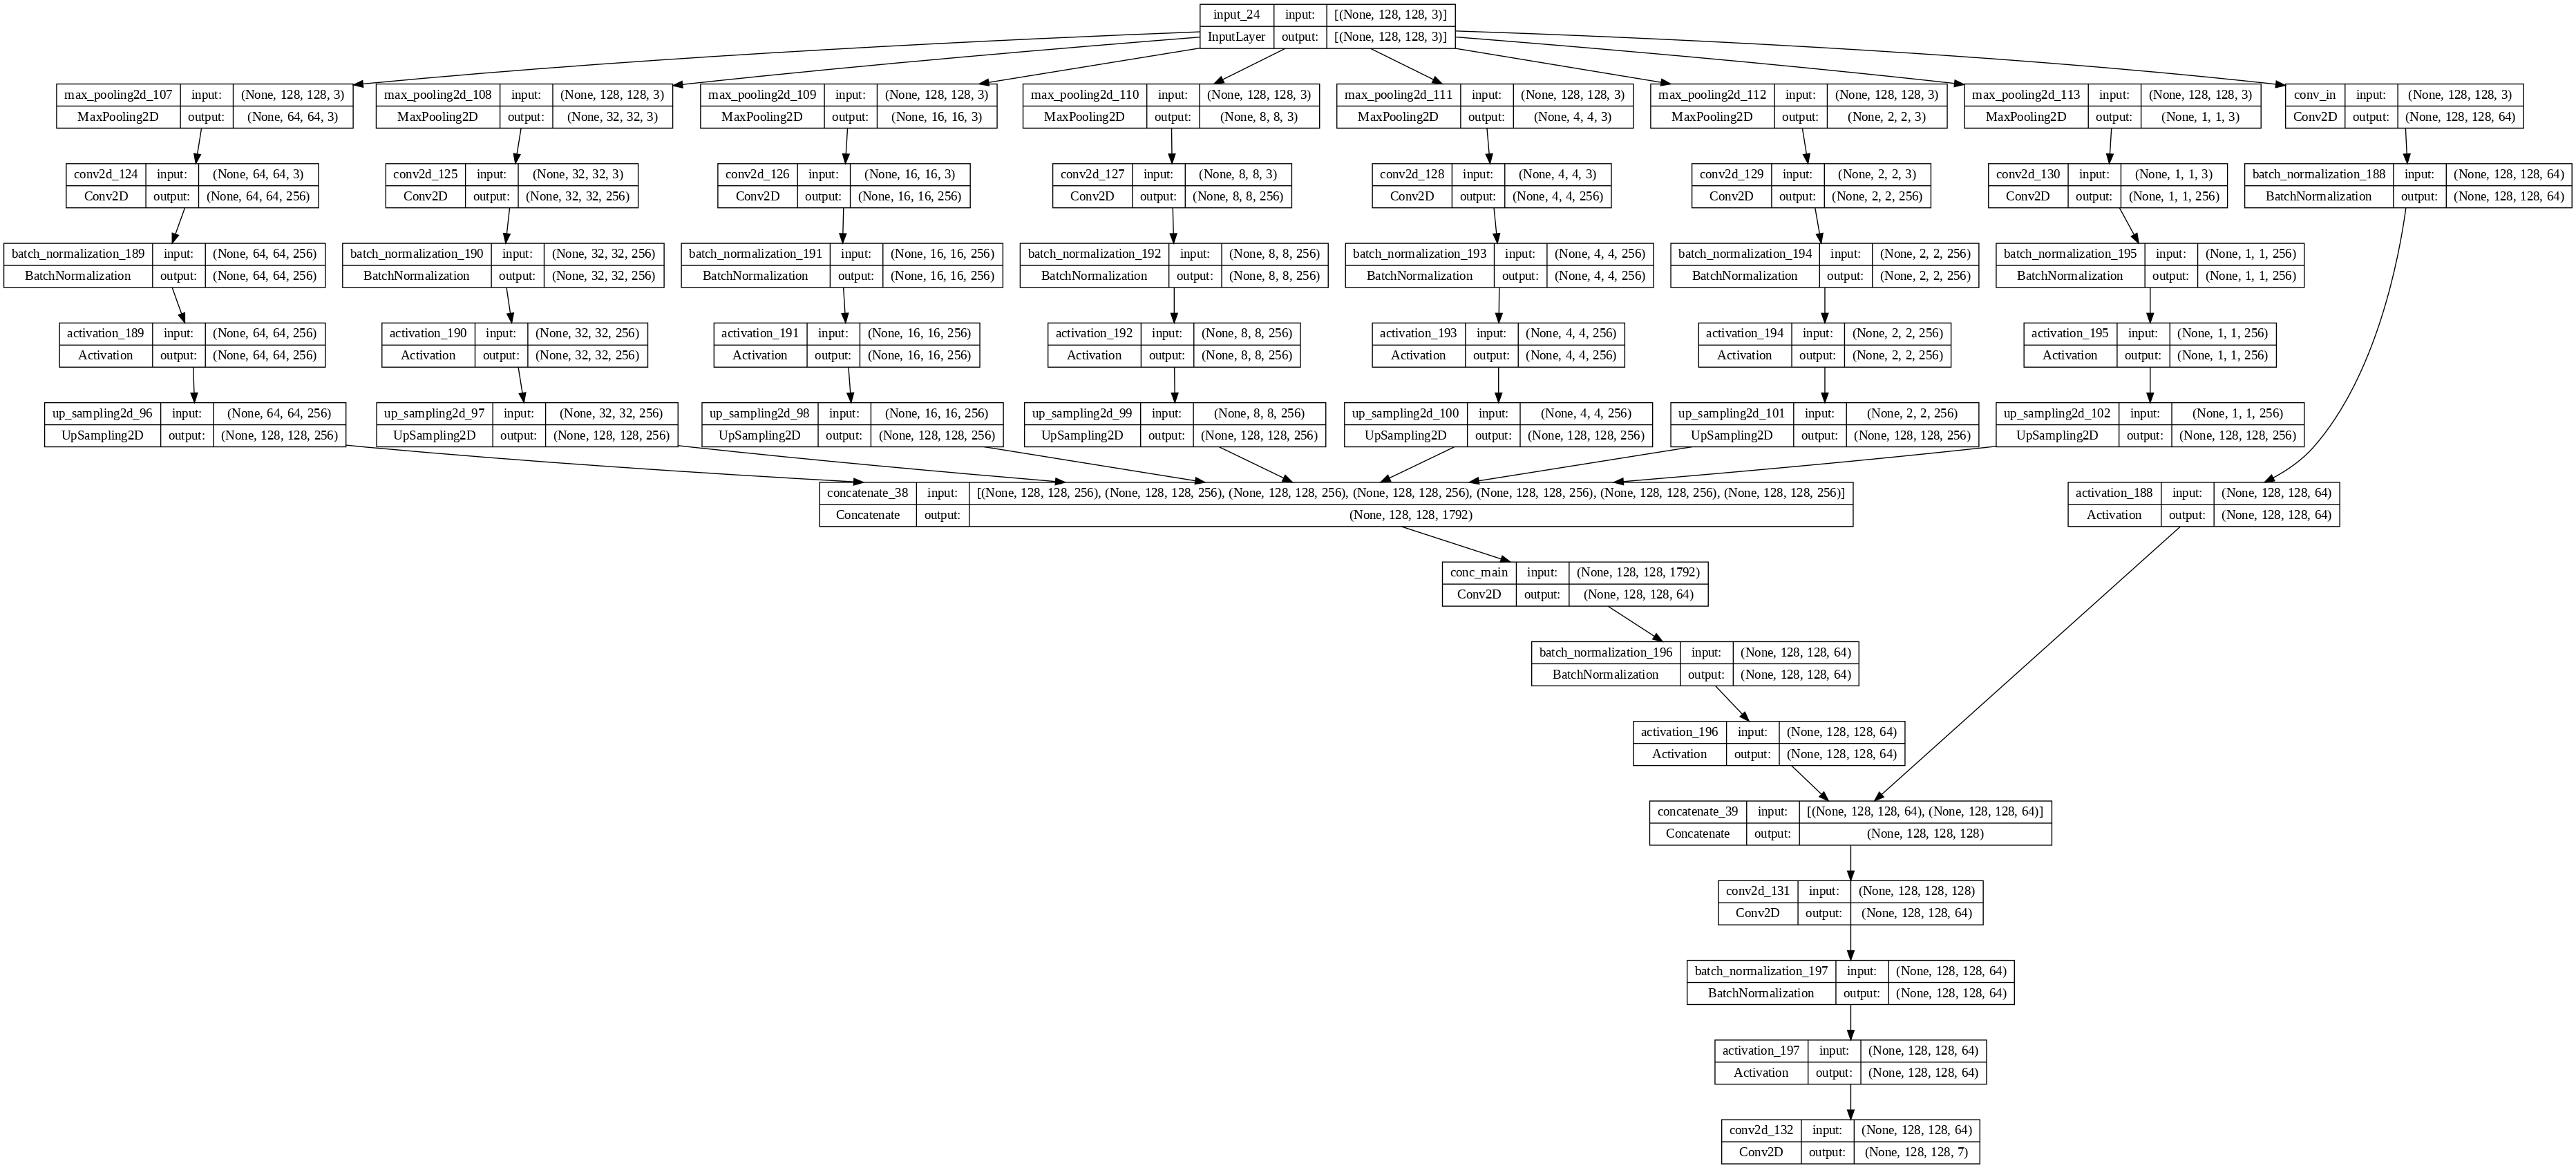

In [73]:
# PSPnet_7levels_more = PSPNet_construct(NUM_CLASSES,(IMG_WIDTH, IMG_HEIGHT, 3),                                      
#                                        filter_main = 8,
#                                        kernel_main = (3,3),
#                                        filter_piramid = 256,
#                                        kernel_piramid = (2,2),
#                                        kernel_out = (3,3),
#                                        activ_main = 'relu',
#                                        activ_piramid = 'elu',
#                                        levels_piramid = 7)   

# # PSPnet_7levels_more = PSPNet_construct(NUM_CLASSES,(IMG_WIDTH, IMG_HEIGHT, 3),                                      
# #                                        filter_main = 256,
# #                                        kernel_main = (2,2),
# #                                        filter_piramid = 128,
# #                                        kernel_piramid = (3,3),
# #                                        kernel_out = (3,3),
# #                                        activ_main = 'elu',
# #                                        activ_piramid = 'elu',
# #                                        levels_piramid = 7)

PSPnet_7levels = PSPNet_construct(NUM_CLASSES,(IMG_WIDTH, IMG_HEIGHT, 3),                                      
                                       filter_main = 64,
                                       kernel_main = (3,3),
                                       filter_piramid = 256,
                                       kernel_piramid = (2,2),
                                       kernel_out = (3,3),
                                       activ_main = 'relu',
                                       activ_piramid = 'elu',
                                       levels_piramid = 7)   


    
PSPnet_7levels.summary()     
utils.plot_model(PSPnet_7levels, show_shapes=True, dpi=100)

# PSPnet_7levels.summary()     
# PSPnet_7levels.summary()     

In [69]:
# Компилируем модель

PSPnet_7levels.compile(optimizer=Adam(learning_rate=1e-3),
                       loss='sparse_categorical_crossentropy',
                       metrics=['sparse_categorical_accuracy'])

reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.1, 
                                      patience=1, 
                                      verbose=0,
                                      min_lr=0.00001)
earlystop=EarlyStopping(monitor='val_loss', 
                        
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None,
                        restore_best_weights=True)

history = PSPnet_7levels.fit(x_train, 
                             y_train, 
                             epochs=10, 
                             batch_size=32,
                             callbacks=[earlystop, 
                                        reduceLROnPlateau, 
                                        # model_checkpoint_callback
                                       ],
                             validation_data = (x_val, y_val)) # Обучаем модель на выборке по трем классам

Epoch 1/10
60/60 [==============================] - 89s 1s/step - loss: 0.9592 - sparse_categorical_accuracy: 0.6507 - val_loss: 1.3788 - val_sparse_categorical_accuracy: 0.4924 - lr: 0.0010
Epoch 2/10
60/60 [==============================] - 87s 1s/step - loss: 0.9415 - sparse_categorical_accuracy: 0.6575 - val_loss: 1.2784 - val_sparse_categorical_accuracy: 0.5121 - lr: 0.0010
Epoch 3/10
60/60 [==============================] - 87s 1s/step - loss: 0.9294 - sparse_categorical_accuracy: 0.6621 - val_loss: 1.2670 - val_sparse_categorical_accuracy: 0.4898 - lr: 0.0010
Epoch 4/10
60/60 [==============================] - 87s 1s/step - loss: 0.9247 - sparse_categorical_accuracy: 0.6640 - val_loss: 1.2779 - val_sparse_categorical_accuracy: 0.5149 - lr: 0.0010
Epoch 5/10
60/60 [==============================] - 87s 1s/step - loss: 0.9085 - sparse_categorical_accuracy: 0.6711 - val_loss: 1.1765 - val_sparse_categorical_accuracy: 0.5602 - lr: 1.0000e-04
Epoch 6/10
60/60 [=======================

KeyboardInterrupt: ignored

In [ ]:
# Отображение графиков обучения модели

plt.figure(figsize=(14, 7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

1/1 [==============================] - 1s 1s/step


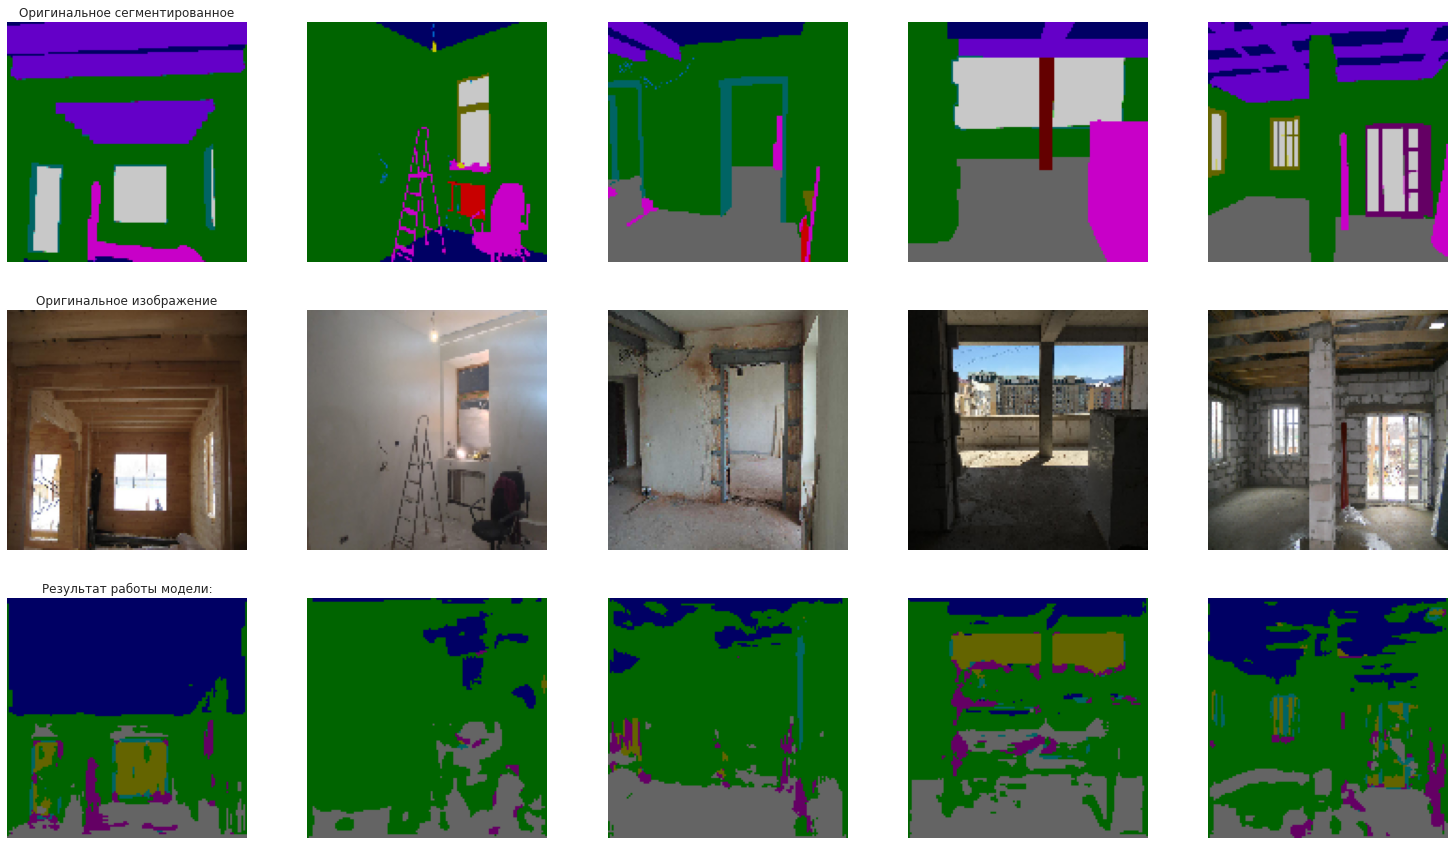

In [71]:
# Отображение результатов работы модели

process_images(PSPnet_7levels, 5, show_prediction=True)